# Initialize pure input state

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, AncillaRegister
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

import math

# from backend.np_backend import state_to_vec
import qtda_modules.qtda_module as qtda
import numpy as np

### Example complex: 0,1,2,3,[01],[12],[13],[23],[30],[013]

In [2]:
n_vertices = 4
S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0), (1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0), (1,1,0,0), (1,0,0,1), (1,0,1,0)]
S2 = [(1,0,1,1)]

In [3]:
S0_vec = qtda.state_to_vec(S0)
S0_vec = S0_vec/np.linalg.norm(S0_vec)

S1_vec = qtda.state_to_vec(S1)
S1_vec = S1_vec/np.linalg.norm(S1_vec)

S2_vec = qtda.state_to_vec(S2)
S2_vec = S2_vec/np.linalg.norm(S2_vec)

# Initialize projector onto subspace

In [4]:
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [17]:
def initialize_projector(state):
    '''initializes projector onto subspace spanned by list of states'''
    
    n_vertices = len(state[0])
    qr1 = QuantumRegister(n_vertices, name="qr1")
    qr2 = AncillaRegister(n_vertices, name="qr2")
    qc = QuantumCircuit(qr1,qr2)
    
    state_vec = be.state_to_vec(state)
    state_vec = state_vec/np.linalg.norm(state_vec)
    qc.initialize(state_vec, qr1)
    qc.barrier()
    for k in range(n_vertices):
        qc.cx(qr1[k],qr2[k])
    qc.barrier()
    return qc

def initialize_circuit_with_projector(state, circuit):
    '''input circuit has to have classical register'''
    qc_proj = initialize_projector(S1)
    qc_proj.add_register(ClassicalRegister(circuit.num_clbits, name="cr_test3"))
    return qc_proj.compose(circuit, qubits=qr1)

In [5]:
n_vertices = 4
S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0), (1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0), (1,1,0,0), (1,0,0,1), (1,0,1,0)]
S2 = [(1,0,1,1)]

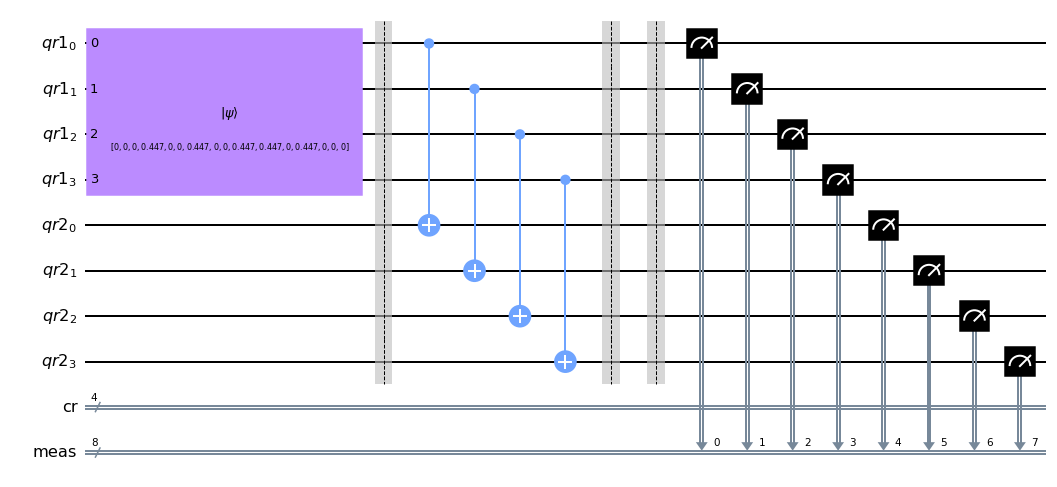

In [6]:
qc = qtda.initialize_projector(S1)
cr = ClassicalRegister(4, name="cr")
qc.add_register(cr)
qc.measure_all()
# qc.measure_all(qr1,cr)
qc.draw('mpl')

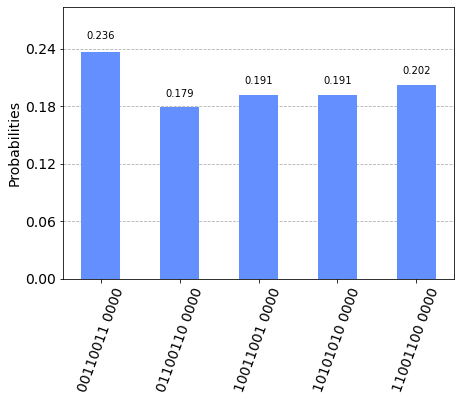

In [27]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
data = job.result().get_counts(qc)
plot_histogram(data)

In [367]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)

### Combining with other circuit

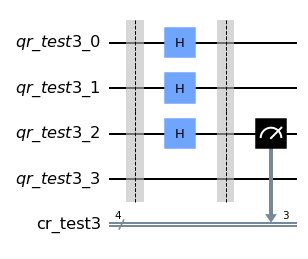

In [368]:
qr_test = QuantumRegister(4, name="qr_test3")
cr_test = ClassicalRegister(4, name="cr_test3")
qc_test = QuantumCircuit(qr_test,cr_test)
qc_test.barrier()
qc_test.h(0)
qc_test.h(1)
qc_test.h(2)
qc_test.barrier()
qc_test.measure(qr_test[2],cr_test[3])
qc_test.draw('mpl')

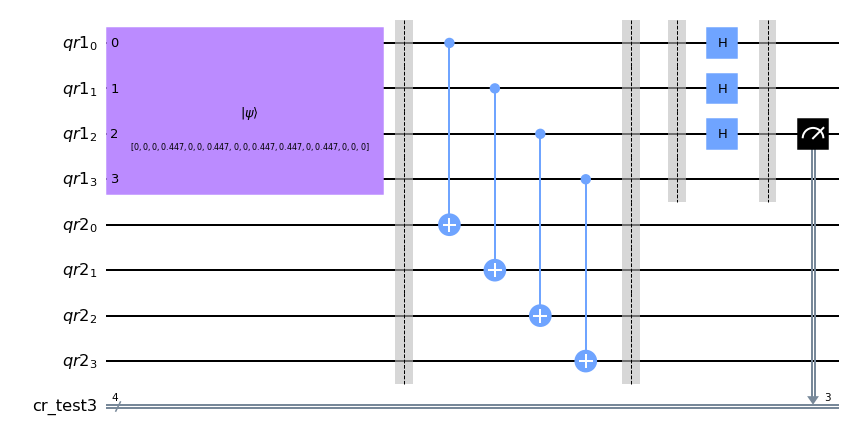

In [369]:
qc_composed = initialize_circuit_with_projector(S1, qc_test)
qc_composed.draw('mpl')

# Testing partial trace

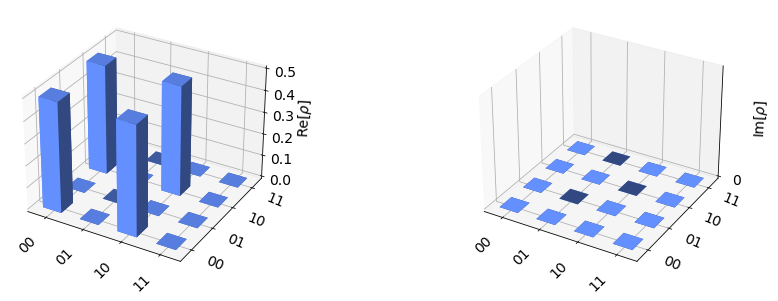

In [370]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.states import Statevector, partial_trace
from qiskit.visualization import plot_state_city

q0 = QuantumRegister(2, 'q0')
q1 = QuantumRegister(2, 'q1')

circuit = QuantumCircuit(q0, q1)
circuit.h(q1[1])
circuit.cswap(q1[1], q1[0], q0[1])
circuit.cx(q1[0], q0[0])
circuit.cx(q0[1], q0[0])
circuit.ccx(q0[0], q1[1], q0[1])

zero_state = Statevector.from_label('0000')
final_state = zero_state.evolve(circuit)

reduced_state = partial_trace(final_state, [0, 1])

plot_state_city(reduced_state.data)